In [1]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F

import math
import time

/work2/04703/sravula/frontera/miniconda3/envs/basic/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:1


# 1. Load the data and get measurements

In [3]:
ROOT_PATH = "/scratch1/04703/sravula/UTAFSDataNew/new_data"
CHIP_NUM = 21

In [4]:
import utils

data_dict = utils.grab_chip_data(ROOT_PATH, CHIP_NUM)

In [5]:
data_dict.keys()

dict_keys(['gt_matrix', 'gt_freqs', 'vf_matrix', 'y_matrix', 'y_freqs'])

## Convert the raw data matrices to only the unique S-parameters

In [6]:
vf_data = utils.matrix_to_sparams(data_dict['vf_matrix'])
gt_data = utils.matrix_to_sparams(data_dict['gt_matrix'])
y_data = utils.matrix_to_sparams(data_dict['y_matrix'])

print("VF S-parameters shape: ", vf_data.shape)
print("GT S-parameters shape: ", gt_data.shape)
print("Y S-parameters shape: ", y_data.shape)

VF S-parameters shape:  (3, 2, 600)
GT S-parameters shape:  (3, 2, 600)
Y S-parameters shape:  (3, 2, 11)


In [7]:
gt_freqs = data_dict['gt_freqs']
y_freqs = data_dict['y_freqs']

print("GT frequencies shape: ", gt_freqs.shape)
print("Y frequencies shape: ", y_freqs.shape)

GT frequencies shape:  (600,)
Y frequencies shape:  (11,)


In [8]:
import scipy as sp

SPACING_EPS = 100

spacings = gt_freqs[1:] - gt_freqs[:-1]

mode_spacing = sp.stats.mode(spacings, keepdims=False)[0]
num_mode = len(np.where(np.abs(spacings-mode_spacing)<SPACING_EPS)[0])

print("First frequency point: ", gt_freqs[0])
print("Mean frequency spacing: ", np.mean(spacings))
print("STD frequency spacing: ", np.std(spacings))
print("Mode frequency spacing: ", mode_spacing)
print("Number of samples with non-equal spacing: ", len(gt_freqs) - num_mode)

First frequency point:  10000000.0
Mean frequency spacing:  50066777.96327212
STD frequency spacing:  33.915272806317695
Mode frequency spacing:  50066800.0
Number of samples with non-equal spacing:  89


## Make some variables we will need

In [9]:
N_FREQS = gt_data.shape[-1]
N_SPARAMS = gt_data.shape[0]  

print("N_FREQS: ", N_FREQS)
print("N_SPARAMS: ", N_SPARAMS)

N_FREQS:  600
N_SPARAMS:  3


In [10]:
x = torch.from_numpy(gt_data).view(-1, N_FREQS).unsqueeze(0).to(device)

print("x shape: ", x.shape)

x shape:  torch.Size([1, 6, 600])


In [11]:
x_mag = utils.sparams_to_mag(x)

print("x_mag shape: ", x_mag.shape)

x_mag shape:  torch.Size([1, 3, 600])


## Grab Some Measurements

In [12]:
PROBLEM_TYPE = "sqrt" #[random, equal, forecast, full, log, sqrt]
M = 0.1

kept_inds, missing_inds = utils.get_inds(PROBLEM_TYPE, N_FREQS, M)

M = len(kept_inds) #re-define in case kept_inds is off by 1 or something

print("Number of Ground Truth Frequency Points: ", N_FREQS)
print("Number of Measurements: ", M)
print("Undersampling Ratio: ", M/N_FREQS)

Number of Ground Truth Frequency Points:  600
Number of Measurements:  60
Undersampling Ratio:  0.1


In [13]:
y = torch.clone(x)[:, :, kept_inds]
y_freqs = gt_freqs[kept_inds]

print("y shape: ", y.shape)
print("y_freqs shape: ", y_freqs.shape)

y shape:  torch.Size([1, 6, 60])
y_freqs shape:  (60,)


In [14]:
y_mag = utils.sparams_to_mag(y)

print("x_mag shape: ", y_mag.shape)

x_mag shape:  torch.Size([1, 3, 60])


## Plot data and measurements

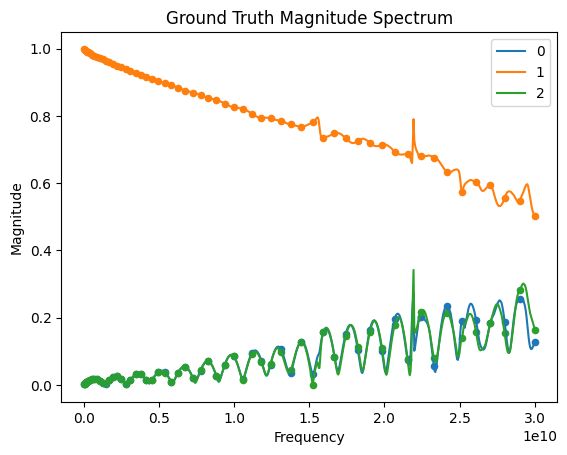

In [15]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x_mag[0, i].cpu(), label=str(i))
    plt.scatter(y_freqs, y_mag[0, i].cpu(), s=20)
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Magnitude Spectrum")
plt.ylabel("Magnitude")
plt.xlabel("Frequency")
plt.show()

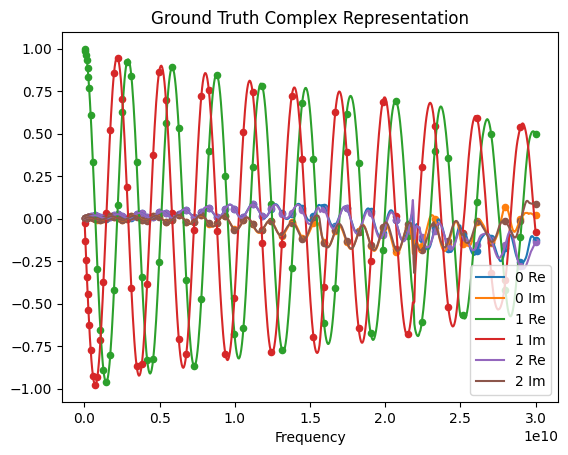

In [16]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" Re")
    plt.plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" Im")
    plt.scatter(y_freqs, y[0,2*i].cpu(), s=20)
    plt.scatter(y_freqs, y[0,2*i+1].cpu(), s=20)
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Complex Representation")
plt.xlabel("Frequency")
plt.show()

# 2. Network Setup

## Define network parameters

In [17]:
NZ = y.shape[1]

NUM_LAYERS = int(np.ceil(np.log2(N_FREQS))) - 4

if NZ < 64:
    BASE_NGF = 2 ** (int(np.ceil(np.log2(NZ))) + 1) #second power of two after NZ 
elif NZ < 128:
    BASE_NGF = 2 ** int(np.ceil(np.log2(NZ))) #next highest power of 2
else:
    BASE_NGF = NZ
NGF = [BASE_NGF] * NUM_LAYERS

BS = y.shape[0]
NC = y.shape[1]

KERNEL_SIZE = 3
USE_SKIP = False
CAUSAL_PASSIVE = True
OPTIMIZE_Z = False

In [18]:
print("NZ: ", str(NZ))
print("NUM_LAYERS: ", str(NUM_LAYERS))
print("BASE NGF: ", str(BASE_NGF))
print("NGF: ", str(NGF))
print("BS: ", BS)
print("NC: ", NC)
print("KERNEL_SIZE: ", KERNEL_SIZE)
print("USE_SKIP: ", USE_SKIP)
print("CAUSAL_PASSIVE: ", CAUSAL_PASSIVE)
print("OPTIMIZE_Z: ", OPTIMIZE_Z)

NZ:  6
NUM_LAYERS:  6
BASE NGF:  16
NGF:  [16, 16, 16, 16, 16, 16]
BS:  1
NC:  6
KERNEL_SIZE:  3
USE_SKIP:  False
CAUSAL_PASSIVE:  True
OPTIMIZE_Z:  False


## Init and check dimensions

In [19]:
from models import RES_UNET

net = RES_UNET(bs=BS,
               nz=NZ,
               ngf=NGF,
               output_size=N_FREQS,
               nc=NC,
               optimize_z=OPTIMIZE_Z,
               kernel_size=KERNEL_SIZE,
               num_layers=NUM_LAYERS,
               use_skip=USE_SKIP,
               causal_passive=CAUSAL_PASSIVE)
net = net.to(device)

In [20]:
test_out = net.forward_with_z()

print("Net output shape: ", test_out.shape)

Net output shape:  torch.Size([1, 6, 600])


In [21]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  21906


# 3. Run

## Define training parameters, losses, and track stats

In [22]:
LR = 1e-4 
NUM_ITER = 10000 

REG_HYPERPARAM = 0.5

In [23]:
NOISY_INPUT = True

START_NOISE_LEVEL = CUR_NOISE_LEVEL = 1
END_NOISE_LEVEL = 0.001
NOISE_DECAY_FACTOR = (END_NOISE_LEVEL / START_NOISE_LEVEL)**(1 / NUM_ITER) 

print("Noise decay factor: ", NOISE_DECAY_FACTOR)

Noise decay factor:  0.9993094630025899


In [24]:
criterion = utils.Measurement_MSE_Loss(kept_inds=kept_inds, per_param=True, reduction="sum")
criterion = criterion.to(device)

if REG_HYPERPARAM > 0:
    regularizer = utils.Smoothing_Loss(per_param=True, reduction="sum")
    regularizer = regularizer.to(device)

In [25]:
net = net.train()

optim = torch.optim.Adam(net.parameters(), lr=LR)

In [26]:
train_losses = []
train_errors = []
if REG_HYPERPARAM > 0:
    train_regs = []

test_mses = []
test_maes = []

## Train DIP

In [27]:
tic = time.time()

for i in range(NUM_ITER):
    optim.zero_grad()
    
    #Get output with noise annealing or without
    if NOISY_INPUT:
        out = net.forward_with_z(CUR_NOISE_LEVEL)
        CUR_NOISE_LEVEL *= NOISE_DECAY_FACTOR
    else:
        out = net.forward_with_z()
    
    #Get the loss with regularization or without
    train_error = criterion(out, y) 
    if REG_HYPERPARAM > 0:
        train_reg = REG_HYPERPARAM * regularizer(out)
        train_loss = train_error + train_reg
    else:
        train_loss = train_error
    
    train_loss.backward()
    optim.step()
    
    #Track metrics and print useful info
    with torch.no_grad():
        train_losses.append(train_loss.item())
        train_errors.append(train_error.item())
        if REG_HYPERPARAM > 0:
            train_regs.append(train_reg.item())
        
        test_mse = nn.MSELoss()(out, x)
        test_mses.append(test_mse.item())
        
        test_mae = nn.L1Loss()(out, x)
        test_maes.append(test_mae.item())

        if (i+1)%1000 == 0 or i == 0:
            toc = time.time()
            print("ITER ", str(i))
            print("TIME: ", str(toc - tic))
            if NOISY_INPUT:
                print("NOISE LEVEL: ", CUR_NOISE_LEVEL)
            print()

ITER  0
TIME:  0.14737439155578613
NOISE LEVEL:  0.9993094630025899

ITER  999
TIME:  26.476194620132446
NOISE LEVEL:  0.5011872336272796

ITER  1999
TIME:  54.401522397994995
NOISE LEVEL:  0.2511886431509651

ITER  2999
TIME:  78.73878312110901
NOISE LEVEL:  0.12589254117942225

ITER  3999
TIME:  102.54683494567871
NOISE LEVEL:  0.06309573444802309

ITER  4999
TIME:  126.45458483695984
NOISE LEVEL:  0.031622776601686116

ITER  5999
TIME:  150.36298775672913
NOISE LEVEL:  0.01584893192461253

ITER  6999
TIME:  174.1635468006134
NOISE LEVEL:  0.007943282347243643

ITER  7999
TIME:  198.25544834136963
NOISE LEVEL:  0.003981071705535453

ITER  8999
TIME:  222.3508017063141
NOISE LEVEL:  0.001995262314969155

ITER  9999
TIME:  246.11384296417236
NOISE LEVEL:  0.0010000000000001527



## Plot metrics and outputs

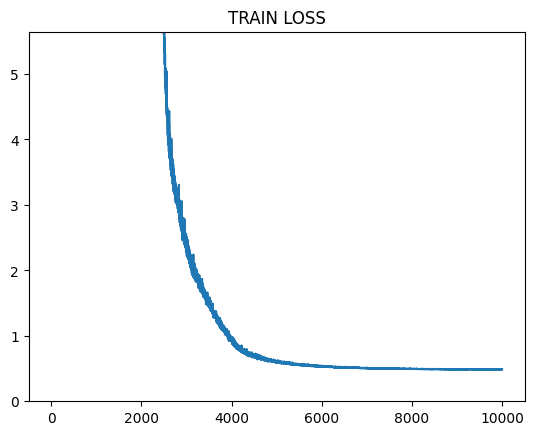

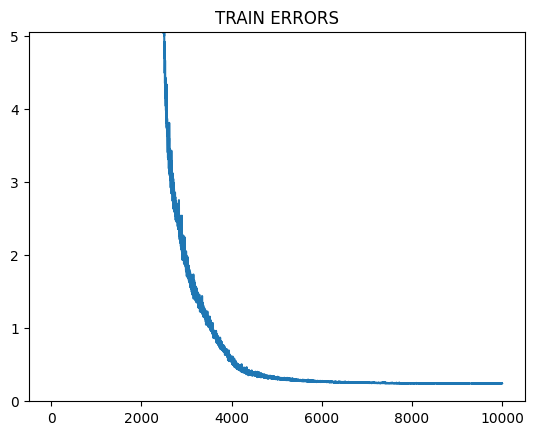

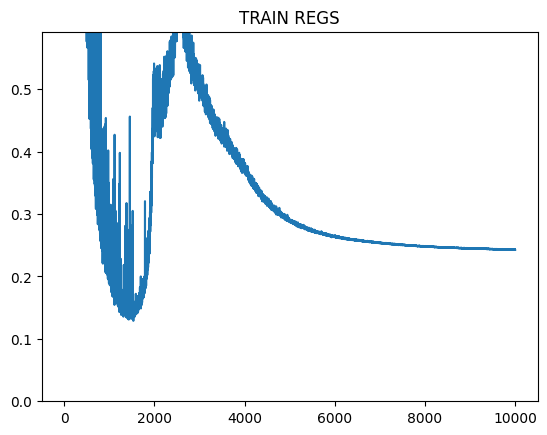

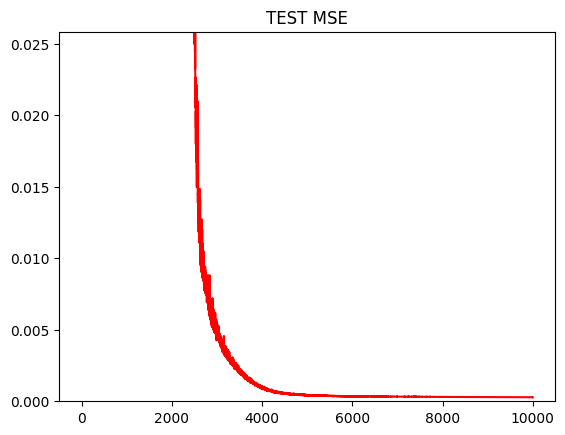

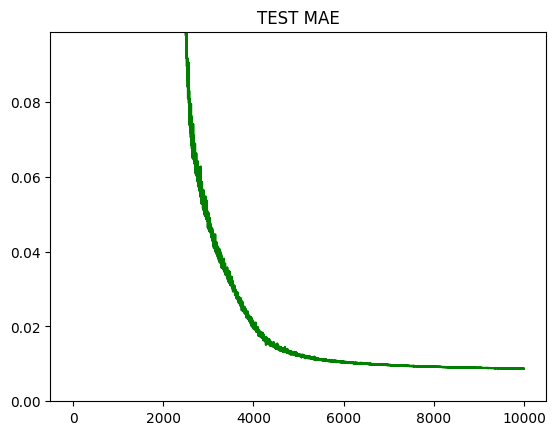

In [28]:
max_idx = 2500

plt.figure()
plt.plot(train_losses)
plt.title("TRAIN LOSS")
plt.ylim(0., train_losses[max_idx])
plt.show()

plt.figure()
plt.plot(train_errors)
plt.title("TRAIN ERRORS")
plt.ylim(0., train_errors[max_idx])
plt.show()

if REG_HYPERPARAM > 0:
    plt.figure()
    plt.plot(train_regs)
    plt.title("TRAIN REGS")
    plt.ylim(0., train_regs[max_idx])
    plt.show()

plt.figure()
plt.plot(test_mses, color='r')
plt.title("TEST MSE")
plt.ylim(0., test_mses[max_idx])
plt.show()

plt.figure()
plt.plot(test_maes, color='g')
plt.title("TEST MAE")
plt.ylim(0, test_maes[max_idx])
plt.show()

In [29]:
print("Final Test MSE: ", test_mses[-1])
print("Best Test MSE: ", np.min(test_mses))
print("Best Test MSE Iteration: ", np.argmin(test_mses))

Final Test MSE:  0.00028051508706994355
Best Test MSE:  0.000280413223663345
Best Test MSE Iteration:  9897


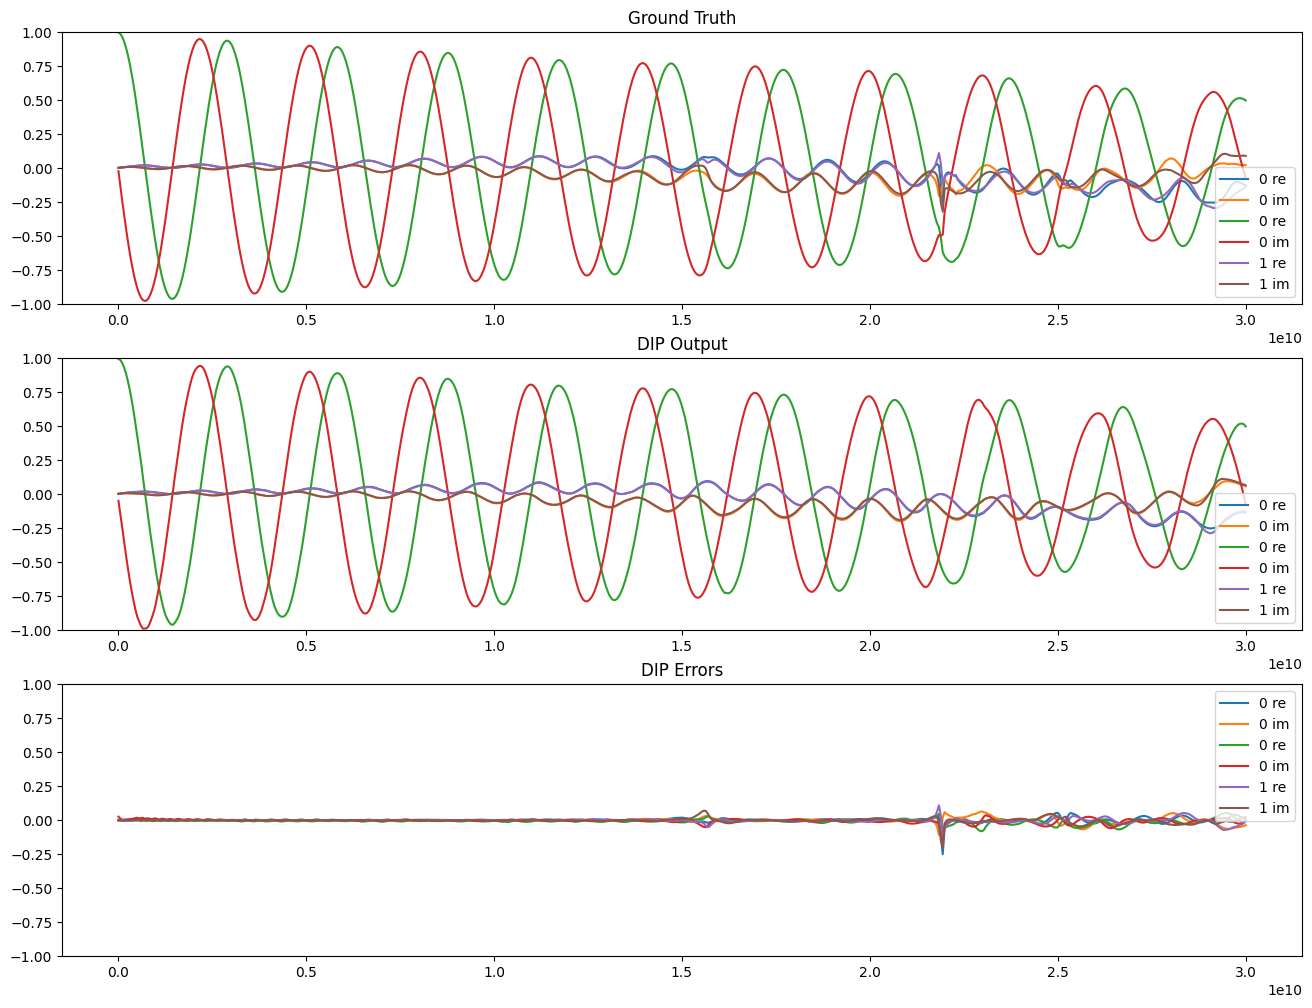

In [30]:
dip_errors = x - out

fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x[0,2*i].cpu(), label=str(i//2)+" re")
    axes[0].plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i//2)+" im")
axes[0].set_title("Ground Truth")
axes[0].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[0].legend()

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out[0,2*i].detach().cpu(), label=str(i//2)+" re")
    axes[1].plot(gt_freqs, out[0,2*i+1].detach().cpu(), label=str(i//2)+" im")
axes[1].set_title("DIP Output")
axes[1].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[1].legend()
    
for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,2*i].detach().cpu(), label=str(i//2)+" re")
    axes[2].plot(gt_freqs, dip_errors[0,2*i+1].detach().cpu(), label=str(i//2)+" im")
axes[2].set_title("DIP Errors")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend()

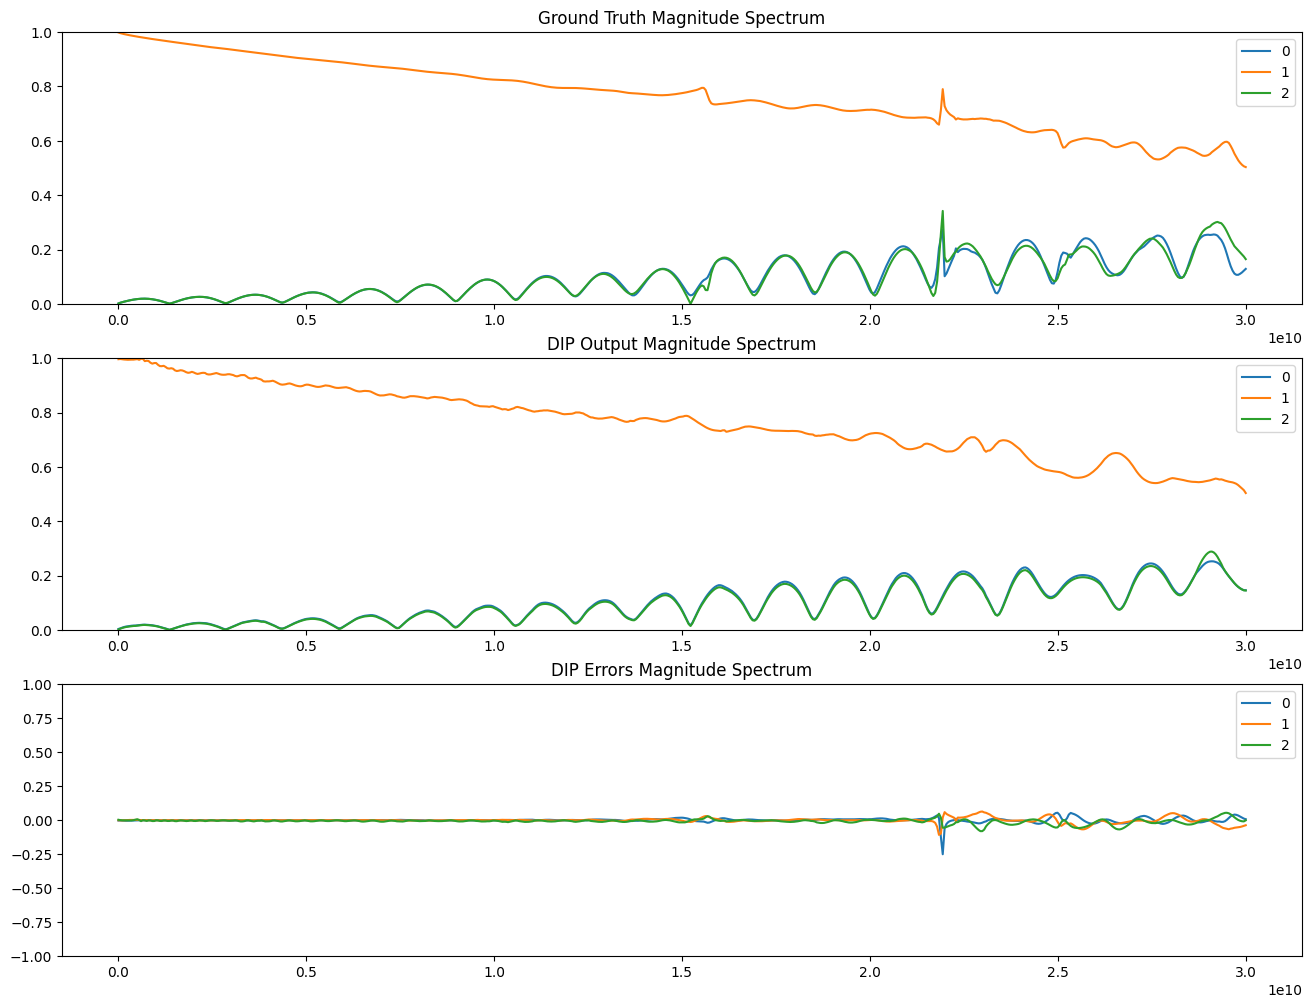

In [31]:
out_mag = utils.sparams_to_mag(out)
dip_errors_mag = x_mag - out_mag 

fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x_mag[0,i].cpu(), label=str(i))
axes[0].set_title("Ground Truth Magnitude Spectrum")
axes[0].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[0].legend()

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out_mag[0,i].detach().cpu(), label=str(i))
axes[1].set_title("DIP Output Magnitude Spectrum")
axes[1].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[1].legend()
    
for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,i].detach().cpu(), label=str(i))
axes[2].set_title("DIP Errors Magnitude Spectrum")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend()

# 4. Saving and Metrics

## Make the saving output filepath

In [32]:
import os 

WRITE_ROOT = "/scratch1/04703/sravula/Siemens_VF_Data_completed/"

if CHIP_NUM==2:
    CASE = "case02"
elif CHIP_NUM==9:
    CASE = "case09"
elif CHIP_NUM==21:
    CASE = "case21"
    
SPACING = PROBLEM_TYPE + "_spacing"

In [33]:
OUT_PTH = os.path.join(WRITE_ROOT, CASE, SPACING)

print(OUT_PTH)

/scratch1/04703/sravula/Siemens_VF_Data_completed/case21/sqrt_spacing


In [34]:
WRITE_PTH = OUT_PTH + "/case" + str(CHIP_NUM) + "_" + PROBLEM_TYPE + "_" + str(M) + ".DIP"

print(WRITE_PTH)

/scratch1/04703/sravula/Siemens_VF_Data_completed/case21/sqrt_spacing/case21_sqrt_60.DIP


## Make a DIP network and convert back for metrics

In [35]:
DIP_OUT_MATRIX = utils.sparams_to_matrix(out)
print(DIP_OUT_MATRIX.shape)

torch.Size([600, 2, 2, 2])


In [36]:
DIP_net = utils.matrix_to_network(DIP_OUT_MATRIX, gt_freqs, "DIP Recon With "+str(M)+" Samples for Chip "+str(CHIP_NUM))

In [37]:
DIP_FINAL_OUT = np.stack((DIP_net.s.real, DIP_net.s.imag), axis=-1)
print(DIP_FINAL_OUT.shape)

(600, 2, 2, 2)


In [38]:
dip_data = utils.matrix_to_sparams(DIP_FINAL_OUT)
print(dip_data.shape)

(3, 2, 600)


## Grab the VF data

In [39]:
from skrf import Network

VF_STR = PROBLEM_TYPE + "_" + str(M) + ".HLAS"

children = os.listdir(OUT_PTH)
children = [f for f in children if VF_STR in f][0]

print(os.path.join(OUT_PTH, children))

VF_net = Network(os.path.join(OUT_PTH, children))

/scratch1/04703/sravula/Siemens_VF_Data_completed/case21/sqrt_spacing/case21_sqrt_60.HLAS.s2p


In [40]:
VF_FINAL_OUT = np.stack((VF_net.s.real, VF_net.s.imag), axis=-1)
print(VF_FINAL_OUT.shape)

(600, 2, 2, 2)


In [41]:
vf_data = utils.matrix_to_sparams(VF_FINAL_OUT)
print(vf_data.shape)

(3, 2, 600)


## Metrics

In [42]:
import skimage.metrics
from skimage.metrics import peak_signal_noise_ratio as psnr

psnr_ours = psnr(gt_data, dip_data)
psnr_vf = psnr(gt_data, vf_data)

print("DIP PSNR: ", psnr_ours)
print("VF PSNR: ", psnr_vf)

DIP PSNR:  41.541037903339266
VF PSNR:  28.740163542860756


## Save the output

In [43]:
DIP_net.write_touchstone(WRITE_PTH+children[-4:])